In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv1D,
    MaxPooling1D,
    LSTM,
    Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping


In [237]:
###############################
# 1) Load & Clean
###############################
file_path = "Price History_IVV_US_Equity.xlsx"
df = pd.read_excel(file_path)
df.rename(columns={"Exchange Date": "Date"}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])
df.sort_values("Date", inplace=True)
df.set_index("Date", inplace=True)

for col in ["Net", "Turnover - USD"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

df.dropna(inplace=True)
print("Data shape after cleaning:", df.shape)


Data shape after cleaning: (5021, 6)


In [238]:
###############################
# 2) Feature Engineering
###############################
df["Log_Returns"] = np.log(df["Close"] / df["Close"].shift(1))
df["Volatility"] = df["Log_Returns"].rolling(10).std()
df["High_Low_Range"] = (df["High"] - df["Low"]) / df["Close"]

# Add EMA features
df["EMA_10"] = df["Close"].ewm(span=10, adjust=False).mean()
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
df["EMA_Diff"] = df["EMA_10"] - df["EMA_20"]

df.dropna(inplace=True)
print("Data shape after feature eng:", df.shape)

# Multi-feature approach
feature_cols = [
    "Open","High","Low","Close","Volume",
    "Log_Returns","High_Low_Range",
    "EMA_10","EMA_20","EMA_Diff"
]
X = df[feature_cols].values
y = df[["Volatility"]].values

print(f"Features used: {feature_cols}")
print("X shape:", X.shape, "y shape:", y.shape)


Data shape after feature eng: (5011, 12)
Features used: ['Open', 'High', 'Low', 'Close', 'Volume', 'Log_Returns', 'High_Low_Range', 'EMA_10', 'EMA_20', 'EMA_Diff']
X shape: (5011, 10) y shape: (5011, 1)


In [239]:
###############################
# 3) Scaling
###############################
X_scaler = StandardScaler()
y_scaler = MinMaxScaler(feature_range=(-1,1))

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [240]:
###############################
# 4) Create Sequences
###############################
sequence_length = 30  # your best results used ~30

def create_sequences(X_data, y_data, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len):
        X_seq.append(X_data[i:i+seq_len])
        y_seq.append(y_data[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)
print("Sequences shape:", X_seq.shape, y_seq.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

Sequences shape: (4981, 30, 10) (4981, 1)


In [241]:
###############################
# 5) Build CNN-LSTM
###############################
def build_cnn_lstm(seq_len, num_features):
    inputs = tf.keras.Input(shape=(seq_len, num_features))
    
    # CNN part
    x = Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # LSTM part
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(1)(x)
    
    # Huber with delta=0.01
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=Huber(delta=0.01)
    )
    return model

model = build_cnn_lstm(X_train.shape[1], X_train.shape[2])
model.summary()


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 30, 10)]          0         
                                                                 
 conv1d_31 (Conv1D)          (None, 30, 128)           3968      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 15, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_32 (Conv1D)          (None, 15, 128)           49280     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 7, 128)            0         
 ng1D)                                                           
                                                                 
 lstm_10 (LSTM)              (None, 7, 128)            131

In [242]:
###############################
# 6) Train Model
###############################
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=400,          # up to 400
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]  # No LR schedule
)


Epoch 1/400
63/63 [==============================] - 7s 45ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 2/400
63/63 [==============================] - 2s 29ms/step - loss: 0.0013 - val_loss: 9.5064e-04
Epoch 3/400
63/63 [==============================] - 2s 26ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/400
63/63 [==============================] - 2s 27ms/step - loss: 9.4229e-04 - val_loss: 0.0011
Epoch 5/400
63/63 [==============================] - 2s 26ms/step - loss: 8.9985e-04 - val_loss: 0.0013
Epoch 6/400
63/63 [==============================] - 2s 29ms/step - loss: 8.6800e-04 - val_loss: 0.0011
Epoch 7/400
63/63 [==============================] - 2s 27ms/step - loss: 8.0802e-04 - val_loss: 0.0019
Epoch 8/400
63/63 [==============================] - 2s 27ms/step - loss: 8.1188e-04 - val_loss: 0.0016
Epoch 9/400
63/63 [==============================] - 2s 28ms/step - loss: 7.6619e-04 - val_loss: 0.0015
Epoch 10/400
63/63 [==============================] - 2s 27ms/step - los

32/32 [==============================] - 0s 7ms/step

Sample Prediction Comparison:
Actual: 0.00566 | Predicted: 0.00536
Actual: 0.00406 | Predicted: 0.00484
Actual: 0.00430 | Predicted: 0.00503
Actual: 0.00622 | Predicted: 0.00431
Actual: 0.00645 | Predicted: 0.00623


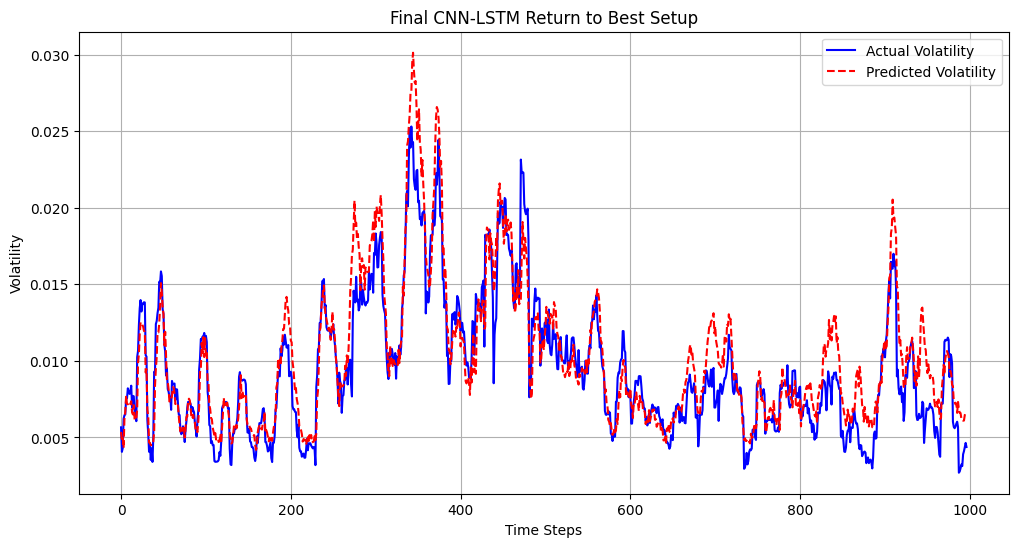

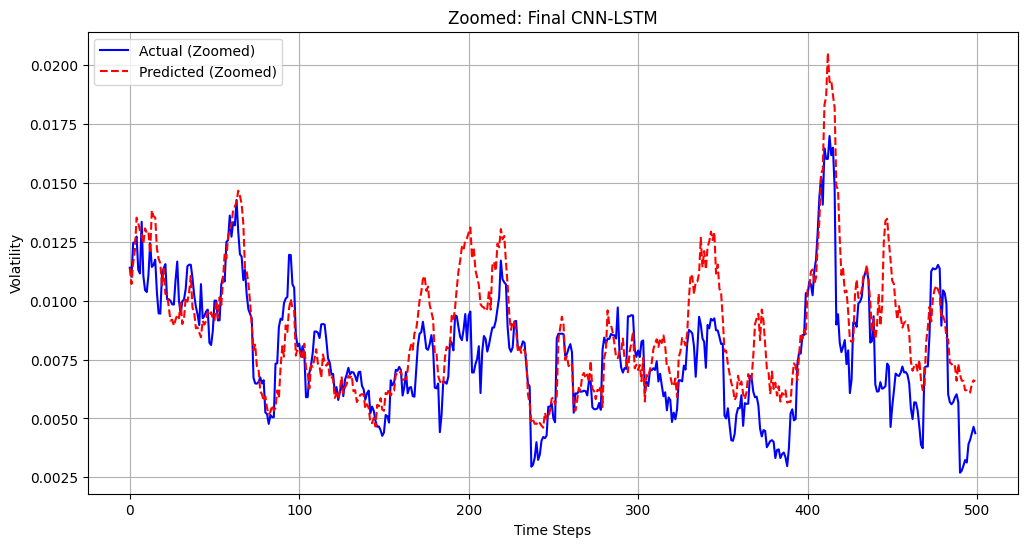

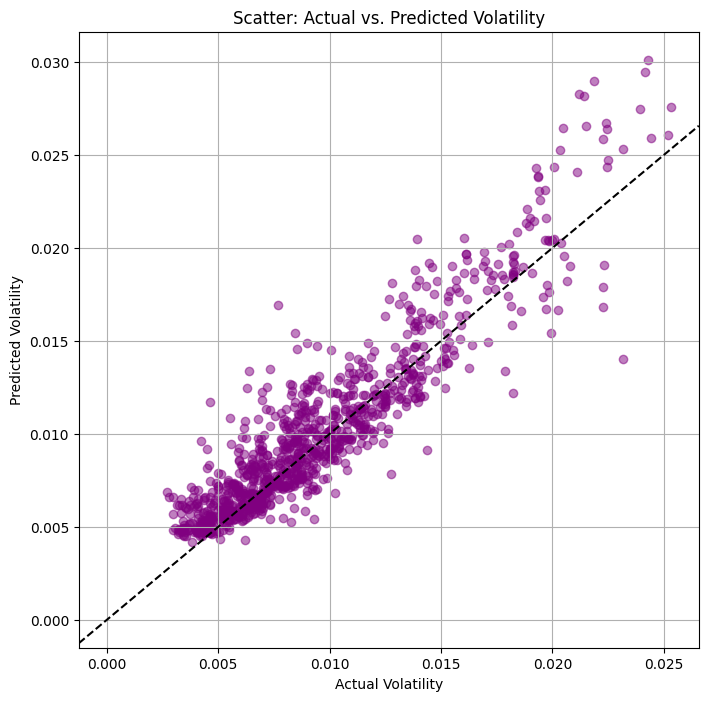


=== Model Performance ===
MSE: 0.000004
MAE: 0.001445
RMSE: 0.001966
R² Score: 0.802854

✅ 'final_cnn_lstm.csv' saved!


In [247]:
###############################
# 7) Evaluate & Save
###############################
y_pred_scaled = model.predict(X_test).reshape(-1, 1)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

num_samples = min(len(y_pred), len(y_true))
y_pred = y_pred[:num_samples]
y_true = y_true[:num_samples]

print("\nSample Prediction Comparison:")
for i in range(5):
    print(f"Actual: {y_true[i][0]:.5f} | Predicted: {y_pred[i][0]:.5f}")

# Plots
plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual Volatility", color='blue')
plt.plot(y_pred, label="Predicted Volatility", color='red', linestyle='dashed')
plt.title("Final CNN-LSTM Return to Best Setup")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.legend()
plt.grid()
plt.show()

# Zoom
zoom_len = 500
zoom_len = min(zoom_len, len(y_true))
y_true_zoom = y_true[-zoom_len:]
y_pred_zoom = y_pred[-zoom_len:]

plt.figure(figsize=(12,6))
plt.plot(y_true_zoom, label="Actual (Zoomed)", color='blue')
plt.plot(y_pred_zoom, label="Predicted (Zoomed)", color='red', linestyle='dashed')
plt.title("Zoomed: Final CNN-LSTM")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.legend()
plt.grid()
plt.show()

# Scatter
plt.figure(figsize=(8,8))
plt.scatter(y_true, y_pred, alpha=0.5, color='purple')
plt.xlabel("Actual Volatility")
plt.ylabel("Predicted Volatility")
plt.title("Scatter: Actual vs. Predicted Volatility")
plt.axline((0, 0), slope=1, color="black", linestyle="dashed")
plt.grid()
plt.show()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\n=== Model Performance ===")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.6f}")

results_df = pd.DataFrame({
    "Date": df.index[-num_samples:],
    "CNN-LSTM Predicted Volatility": y_pred.flatten(),
    "Actual Volatility": y_true.flatten()
})
results_df.set_index("Date", inplace=True)
results_df.to_csv("final_cnn_lstm.csv")
print("\n✅ 'final_cnn_lstm.csv' saved!")

In [263]:
model.save("latest_model_latest.h5")

/Users/god/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [265]:
import joblib 

joblib.dump(X_scaler, "X_scalerR.pkl")
joblib.dump(y_scaler, "y_scalerR.pkl")

['y_scalerR.pkl']

In [248]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

In [258]:
# 1) Fetch latest 1 month of data for 'IVV' to get a rolling window
ticker = "IVV"
print(f"Fetching latest data for {ticker} from Yahoo Finance...")

# Adjust the 'period' or 'interval' as needed
latest_data = yf.download(ticker, period="1y", interval="1d")


# If your original features require columns [Open, High, Low, Close, Volume, etc.]
# rename them or confirm they match your training pipeline
latest_data.rename(columns={
    "Open": "Open",
    "High": "High",
    "Low": "Low",
    "Close": "Close",
    "Volume": "Volume"
}, inplace=True)

latest_data.dropna(inplace=True)

print(latest_data.tail())

[*********************100%***********************]  1 of 1 completed

Fetching latest data for IVV from Yahoo Finance...
Price            Close        High         Low        Open    Volume
Ticker             IVV         IVV         IVV         IVV       IVV
Date                                                                
2025-03-11  558.640015  565.479980  554.640015  561.989990  13308900
2025-03-12  561.479980  565.750000  556.299988  564.820007  11461400
2025-03-13  554.059998  561.650024  552.280029  561.130005  26587800
2025-03-14  565.559998  566.530029  554.070007  558.690002   9822900
2025-03-17  567.722473  569.000000  565.114990  565.409973    712861


In [259]:
# 2) Prepare the data to match your feature-engineering pipeline
# For example, if your model used:
#   - Rolling 10-day volatility
#   - Log_Returns
#   - High_Low_Range
#   - EMA_10, EMA_20, EMA_Diff
# Make sure to replicate that logic:

latest_data["Log_Returns"] = np.log(latest_data["Close"] / latest_data["Close"].shift(1))
latest_data["Volatility"] = latest_data["Log_Returns"].rolling(10).std()
latest_data["High_Low_Range"] = (latest_data["High"] - latest_data["Low"]) / latest_data["Close"]

# EMAs
latest_data["EMA_10"] = latest_data["Close"].ewm(span=10, adjust=False).mean()
latest_data["EMA_20"] = latest_data["Close"].ewm(span=20, adjust=False).mean()
latest_data["EMA_Diff"] = latest_data["EMA_10"] - latest_data["EMA_20"]

latest_data.dropna(inplace=True)

# Now scale the features using your previously fit scalers: X_scaler, y_scaler
# (Assuming you've already loaded them or have them in memory from your training script.)
# We'll call them X_scaler, y_scaler here:

feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Log_Returns", "High_Low_Range",
    "EMA_10", "EMA_20", "EMA_Diff"
]


In [260]:
# 3) Create sequence for multi-step forecast
#   We'll do a naive approach: we take the last 'sequence_length' rows as our input
#   Then do a day+1 prediction, append it, shift, day+2, etc. for 7 days

sequence_length = 30  # matches your model
num_steps_ahead = 7   # next 7 days forecast

# We'll store predictions in a list
predicted_vols = []

# Use the last 'sequence_length' portion from 'latest_data'
df_for_pred = latest_data.copy()
df_for_pred_scaled = X_scaler.transform(df_for_pred[feature_cols])  # shape: (N, features)

# We'll do a rolling multi-step forecast
for step in range(num_steps_ahead):
    # Take the last 'sequence_length' rows
    if len(df_for_pred_scaled) < sequence_length:
        print("Not enough data for multi-step forecast.")
        break
    
    window_input = df_for_pred_scaled[-sequence_length:]  # shape: (30, features)
    
    # Reshape for model: (1, seq_len, features)
    window_input_reshaped = window_input[np.newaxis, :, :]
    
    # Predict scaled volatility
    pred_scaled = model.predict(window_input_reshaped)
    # Inverse transform
    pred_vol = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0,0]
    predicted_vols.append(pred_vol)
    
    # Append a "fake" row to df_for_pred_scaled for day+step
    # If you need daily features, you'll have to guess or use today's data for tomorrow, etc.
    # We'll just replicate the last row except we do not actually know tomorrow's price. This is a naive approach:
    next_row = df_for_pred_scaled[-1].copy()
    # You could set Log_Returns to 0, etc. or do a placeholder. We'll just keep it same as last row for demo.
    # In a real approach, you'd incorporate your price predictions or no info.
    
    # Add the new "row" to the scaled data
    df_for_pred_scaled = np.vstack([df_for_pred_scaled, next_row])

print("Next 7-day predicted volatilities:", predicted_vols)

1/1 [==============================] - 0s 28ms/step
Next 7-day predicted volatilities: [0.025728505, 0.02383102, 0.023252962, 0.02206343, 0.0196776, 0.019800311, 0.018268257]


In [261]:
# 4) Combine with Price-Change Insights
#   Let's assume you want daily returns or % changes. We might do a simplistic approach:
#   We'll just store them in a DataFrame for demonstration.

prediction_dates = []
last_date = latest_data.index[-1]
for i in range(1, num_steps_ahead+1):
    next_date = last_date + pd.Timedelta(days=i)
    # skip weekends if you want. We'll keep it simple
    prediction_dates.append(next_date)

forecast_df = pd.DataFrame({
    "Predicted_Volatility": predicted_vols
}, index=prediction_dates)

print("\nForecast for next 7 days:\n", forecast_df)


Forecast for next 7 days:
             Predicted_Volatility
2025-03-18              0.025729
2025-03-19              0.023831
2025-03-20              0.023253
2025-03-21              0.022063
2025-03-22              0.019678
2025-03-23              0.019800
2025-03-24              0.018268


In [262]:
# 5) Basic VaR/ES calculations (Parametric Approach, e.g. normal assumption)
#   We'll assume daily returns ~ N(0, predicted_vol^2). This is a naive approach.

# Example: For day i in next 7, if predicted_vol ~ stdev of daily returns, then:
#   VaR(95%) = -Z(0.95)*stdev = -1.645 * predicted_vol
#   ES(95%) ~ - (predicted_vol * (exp(-1.645^2/2) / (0.05*sqrt(2*pi))) ) if we do normal approx
#   We'll do a simplistic approach:

alpha = 0.95
z_alpha = 1.645  # 95% from normal table
factor = 1 / (1 - alpha) * (1 / np.sqrt(2*np.pi)) * np.exp(-0.5 * z_alpha**2)

VaRs = []
ESs = []
for vol in forecast_df["Predicted_Volatility"]:
    # parametric daily returns ~ Normal(mean=0, stdev=vol)
    # VaR_95 = z_alpha * vol
    var_95 = z_alpha * vol
    # ES_95 approx for normal: ES = stdev * factor
    es_95 = vol * factor
    VaRs.append(var_95)
    ESs.append(es_95)

forecast_df["Param_VaR(95%)"] = VaRs
forecast_df["Param_ES(95%)"] = ESs

print("\nForecast w/ param VaR & ES:\n", forecast_df)



Forecast w/ param VaR & ES:
             Predicted_Volatility  Param_VaR(95%)  Param_ES(95%)
2025-03-18              0.025729        0.042323       0.053058
2025-03-19              0.023831        0.039202       0.049145
2025-03-20              0.023253        0.038251       0.047953
2025-03-21              0.022063        0.036294       0.045500
2025-03-22              0.019678        0.032370       0.040579
2025-03-23              0.019800        0.032572       0.040833
2025-03-24              0.018268        0.030051       0.037673
